# Term Project03 - DSC680,Fall 2024 - T301 Applied Data Science(2251-1)


## Project03 Title:  TweetSentiment - Social Media Insights

In [1]:
# Assignment: Project03 - Milestone 03
# Author by:  Debabrata Mishra
# Date: 2024-11-16

# Project03- Milestone 03 - Python Code

## Data Set Overview

In [2]:
# Imports
import pandas as pd
import numpy as np
from tabulate import tabulate

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import re
import nltk
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
from joblib import parallel_backend

import warnings
warnings.simplefilter("ignore", category=Warning)

In [3]:
 # Load the training dataset without headers
train_df = pd.read_csv('twitter_training.csv', header=None)

# Load the validation dataset without headers
val_df = pd.read_csv('twitter_validation.csv', header=None)

# Define the headers
headers = ['Tweet_ID', 'Entity', 'Sentiment', 'Tweet_content']

# Assign the headers to the training dataset
train_df.columns = headers
 
# Assign the headers to the validation dataset
val_df.columns = headers

# Combine the training and validation datasets
combined_df = pd.concat([train_df, val_df], keys=['Train', 'Validation'])

# Reset index to use dataset labels in visualization
combined_df.reset_index(level=0, inplace=True)
combined_df.rename(columns={'level_0': 'Dataset'}, inplace=True)


# Print the dimensions (number of rows and columns) of the dataset.
num_rows, num_cols = combined_df.shape
print("\nNumber of rows in the Dataset    : ", num_rows)
print("Number of columns in the Dataset : ", num_cols)

# Print the first 5 rows of the dataset.
print("\n")
combined_df.head()


Number of rows in the Dataset    :  75682
Number of columns in the Dataset :  5




,Dataset,Tweet_ID,Entity,Sentiment,Tweet_content
0,Train,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,Train,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,Train,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,Train,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,Train,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [4]:
# visualize column informations

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75682 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Dataset        75682 non-null  object
 1   Tweet_ID       75682 non-null  int64 
 2   Entity         75682 non-null  object
 3   Sentiment      75682 non-null  object
 4   Tweet_content  74996 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.5+ MB


In [5]:
# Add a column for tweet length in Combined dataset
combined_df['Tweet_length'] = combined_df['Tweet_content'].str.len()

# Display basic statistics for tweet lengths in the Combined dataset
print("Tweet length statistics for the Combined dataset:")
print(combined_df['Tweet_length'].describe())

Tweet length statistics for the Combined dataset:
count    74996.000000
mean       109.091205
std         79.600123
min          1.000000
25%         47.000000
50%         91.000000
75%        153.000000
max        957.000000
Name: Tweet_length, dtype: float64


The combined dataset has 74,996 tweets with an average length of 109.09 characters. The tweet  lengths vary from 1 to 957 characters. Most tweets are between 47 and 153 characters long, with  a standard deviation of 79.6 characters

In [6]:
# Check for NaN values in Combined dataset
print("NaN values in Combined dataset:")
print(combined_df.isna().sum())

NaN values in Combined dataset:
Dataset            0
Tweet_ID           0
Entity             0
Sentiment          0
Tweet_content    686
Tweet_length     686
dtype: int64


The combined dataset has 686 NaN values in both Tweet_content and Tweet_length.

In [7]:
# Check for duplicated rows in Combined dataset
print("Duplicated rows in Combined dataset:", combined_df.duplicated().sum())

Duplicated rows in Combined dataset: 2700


## Data Preparation

In [8]:
# Remove duplicated rows from the Combined dataset
combined_df = combined_df.drop_duplicates()

# Remove rows with NaN values from the Combined dataset
combined_df = combined_df.dropna()

# Verify the changes
print("------------------------------------------------------")
print("Duplicated rows in Combined dataset:", combined_df.duplicated().sum())
print("------------------------------------------------------")
print("\nNaN values in Combined dataset:")
print(combined_df.isna().sum())
print("------------------------------------------------------")

combined_df.info()

------------------------------------------------------
Duplicated rows in Combined dataset: 0
------------------------------------------------------

NaN values in Combined dataset:
Dataset          0
Tweet_ID         0
Entity           0
Sentiment        0
Tweet_content    0
Tweet_length     0
dtype: int64
------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 72656 entries, 0 to 999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Dataset        72656 non-null  object 
 1   Tweet_ID       72656 non-null  int64  
 2   Entity         72656 non-null  object 
 3   Sentiment      72656 non-null  object 
 4   Tweet_content  72656 non-null  object 
 5   Tweet_length   72656 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 3.9+ MB


In [9]:
# Ensure 'Tweet_content' column is string and handle NaN values
combined_df['Tweet_content'] = combined_df['Tweet_content'].astype(str).fillna('')

In [10]:
# Remove URLs
combined_df['Cleaned_Tweet'] = combined_df['Tweet_content'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x))
print("\nAfter removing URLs (Combined):")
print(combined_df[['Tweet_content', 'Cleaned_Tweet']].head())


After removing URLs (Combined):
                                       Tweet_content  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you ...   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands 2 and i will murder ...   

                                       Cleaned_Tweet  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  


In [11]:
# Remove mentions and hashtags
combined_df['Cleaned_Tweet'] = combined_df['Cleaned_Tweet'].apply(lambda x: re.sub(r'@\w+', '', x))
combined_df['Cleaned_Tweet'] = combined_df['Cleaned_Tweet'].apply(lambda x: re.sub(r'#\w+', '', x))

In [12]:
# Remove non-alphabetic characters
combined_df['Cleaned_Tweet'] = combined_df['Cleaned_Tweet'].apply(lambda x: re.sub(r'\d+', '', x))
combined_df['Cleaned_Tweet'] = combined_df['Cleaned_Tweet'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [13]:
# Tokenization
combined_df['Tokens'] = combined_df['Cleaned_Tweet'].apply(word_tokenize)

print("\nAfter tokenization :")
print(combined_df[['Cleaned_Tweet', 'Tokens']].head())


After tokenization :
                                       Cleaned_Tweet  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you all   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands  and i will murder y...   

                                              Tokens  
0  [im, getting, on, borderlands, and, i, will, m...  
1  [I, am, coming, to, the, borders, and, I, will...  
2  [im, getting, on, borderlands, and, i, will, k...  
3  [im, coming, on, borderlands, and, i, will, mu...  
4  [im, getting, on, borderlands, and, i, will, m...  


In [14]:
# Lowercase normalization

combined_df['Tokens'] = combined_df['Tokens'].apply(lambda x: [word.lower() for word in x])

print("\nAfter lowercase normalization:")
print(combined_df[['Cleaned_Tweet', 'Tokens']].head())


After lowercase normalization:
                                       Cleaned_Tweet  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you all   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands  and i will murder y...   

                                              Tokens  
0  [im, getting, on, borderlands, and, i, will, m...  
1  [i, am, coming, to, the, borders, and, i, will...  
2  [im, getting, on, borderlands, and, i, will, k...  
3  [im, coming, on, borderlands, and, i, will, mu...  
4  [im, getting, on, borderlands, and, i, will, m...  


In [15]:
# Remove Stopwaords

stop_words = set(stopwords.words('english'))

combined_df['Tokens'] = combined_df['Tokens'].apply(lambda x: [word for word in x if word not in stop_words])

print("\nAfter removing stopwords:")
print(combined_df[['Cleaned_Tweet', 'Tokens']].head())



After removing stopwords:
                                       Cleaned_Tweet  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you all   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands  and i will murder y...   

                               Tokens  
0  [im, getting, borderlands, murder]  
1             [coming, borders, kill]  
2    [im, getting, borderlands, kill]  
3   [im, coming, borderlands, murder]  
4  [im, getting, borderlands, murder]  


In [16]:
# Lemmatization

lemmatizer = WordNetLemmatizer()
combined_df['Tokens'] = combined_df['Tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

print("\nAfter lemmatization:")
print(combined_df[['Cleaned_Tweet', 'Tokens']].head())


After lemmatization:
                                       Cleaned_Tweet  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you all   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands  and i will murder y...   

                              Tokens  
0  [im, getting, borderland, murder]  
1             [coming, border, kill]  
2    [im, getting, borderland, kill]  
3   [im, coming, borderland, murder]  
4  [im, getting, borderland, murder]  


In [17]:
# Remove short words

combined_df['Tokens'] = combined_df['Tokens'].apply(lambda x: [word for word in x if len(word) > 2])

print("\nAfter removing short words:")
print(combined_df[['Cleaned_Tweet', 'Tokens']].head())



After removing short words:
                                       Cleaned_Tweet  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you all   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands  and i will murder y...   

                          Tokens  
0  [getting, borderland, murder]  
1         [coming, border, kill]  
2    [getting, borderland, kill]  
3   [coming, borderland, murder]  
4  [getting, borderland, murder]  


In [18]:
# Join tokens back into a string

combined_df['Cleaned_Tweet'] = combined_df['Tokens'].apply(lambda x: ' '.join(x))

print("\nFinal Cleaned Combined Dataset:")
print(combined_df[['Tweet_content', 'Cleaned_Tweet']].head())



Final Cleaned Combined Dataset:
                                       Tweet_content  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you ...   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands 2 and i will murder ...   

               Cleaned_Tweet  
0  getting borderland murder  
1         coming border kill  
2    getting borderland kill  
3   coming borderland murder  
4  getting borderland murder  


In [19]:
# Calculate the different values and their count in the 'Sentiment ' column (Target Variable)
status_distribution = combined_df['Sentiment'].value_counts()

print("Distribution of values in 'Sentiment' column:")
print(status_distribution)

Distribution of values in 'Sentiment' column:
Sentiment
Negative      21964
Positive      19990
Neutral       17993
Irrelevant    12709
Name: count, dtype: int64


## Data Visualization

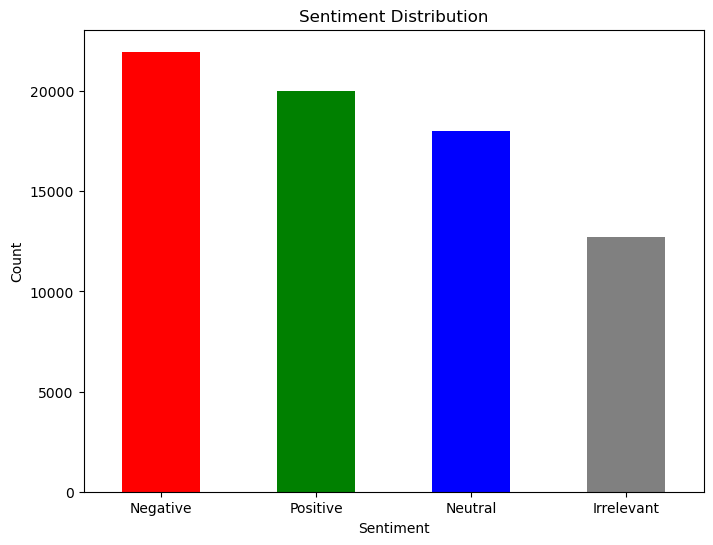

In [24]:
# 1. Bar Chart: Sentiment Distribution
sentiment_counts = combined_df['Sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['red', 'green', 'blue', 'grey'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

The histogram reveals that negative sentiment is the most frequent among tweets, followed by positive sentiment, with neutral and irrelevant sentiments being less common. This distribution provides valuable insight into the overall mood within the dataset, underscoring the dominance of negative sentiment. This finding can inform deeper analyses, such as examining the reasons behind the negative sentiment, monitoring shifts over time, or comparing sentiment patterns across various topics or demographic groups.

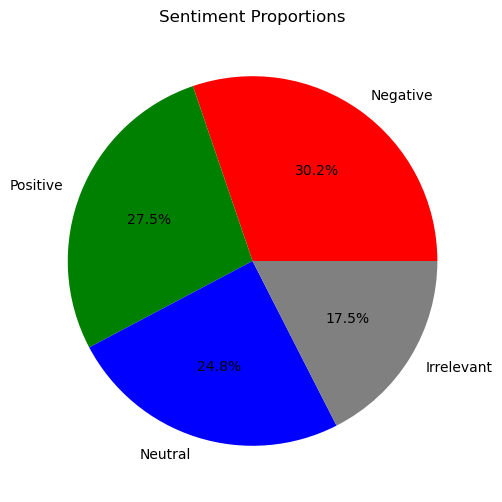

In [25]:
# 2. Pie Chart: Proportion of Sentiments 
sentiment_counts = combined_df['Sentiment'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%',colors=['red', 'green', 'blue', 'grey'])
plt.title('Sentiment Proportions')
plt.show()

The pie chart shows that negative sentiment is the most prominent category, taking up the largest segment. Positive sentiment is present as well but appears less frequently than negative sentiment, while neutral and irrelevant sentiments form smaller portions of the dataset. This visualization offers a clear overview of sentiment distribution, essential for model training and data analysis. Recognizing the predominance of negative sentiment can guide model focus, particularly in enhancing the detection and classification of negative sentiment types.

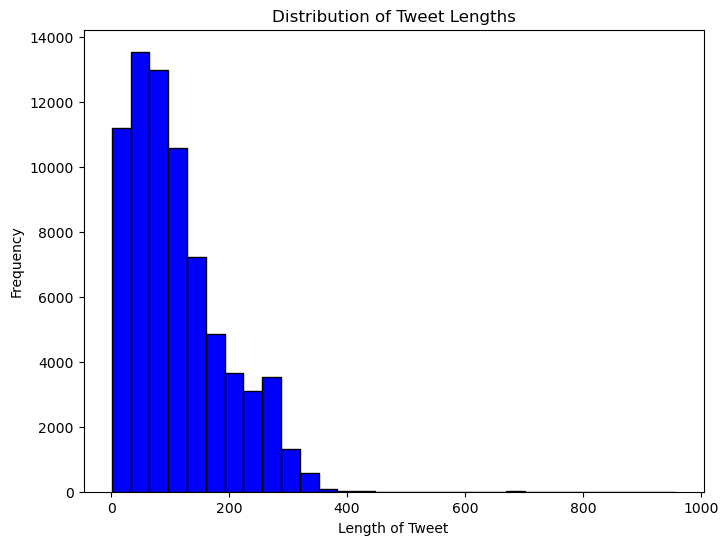

In [27]:
# 3. Histogram: Distribution of Tweet Lengths 

combined_df['Tweet_Length'] = combined_df['Tweet_content'].apply(len)
plt.figure(figsize=(8, 6))
plt.hist(combined_df['Tweet_Length'], bins=30, color='blue',edgecolor='black')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length of Tweet')
plt.ylabel('Frequency')
plt.show()

The histogram displays a right-skewed distribution, with the majority of tweets being short (under 100 characters). The highest frequency appears in this shorter length range, with a long tail extending to around 800 characters, indicating a smaller proportion of significantly longer tweets. Tweet lengths span from 0 to 1000 characters. This visualization sheds light on tweet length patterns, which can be valuable for feature engineering and model training. Recognizing that most tweets are brief can help shape text preprocessing steps and feature extraction strategies, such as adjusting n-gram ranges or managing truncation.

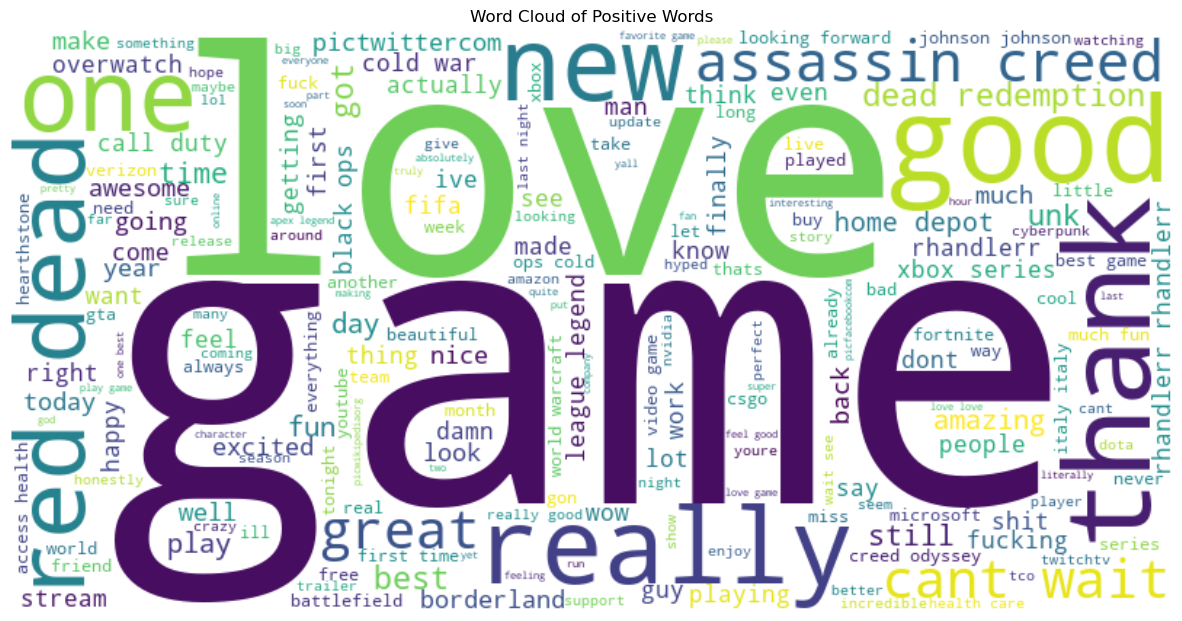

In [28]:
# 4. Word Cloud: Most Frequent Positive Words

text = ' '.join([word for tokens in combined_df['Tokens'].dropna() for word in tokens])
positive_text = ' '.join([word for tokens in combined_df[combined_df['Sentiment'] == 'Positive']['Tokens'].dropna() 
                          for word in tokens])

negative_text = ' '.join([word for tokens in combined_df[combined_df['Sentiment'] == 'Negative']['Tokens'].dropna() 
                          for word in tokens])

 # Generate Word Cloud for Positive Sentiments
    
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Plot the Positive Word Cloud
plt.figure(figsize=(15, 10)) # Adjusted size for better visualization
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Words')
plt.show()

The word cloud highlights the most frequently occurring positive terms in the dataset. Key themes include gaming-related terms (like “game,” “PlayStation,” “Call of Duty”), expressions of positivity (such as “love,” “great,” “happy”), and technology-related words (like “update,” “technology”). Words related to community and social interaction are also prominent. This visualization helps quickly identify central topics and sentiments within the dataset. For model and data analysis, the word cloud supports feature selection by showcasing prominent keywords and themes, ensuring key terms are considered. It also provides context for the dataset’s focus, informing sentiment model design and aiding in results interpretation.

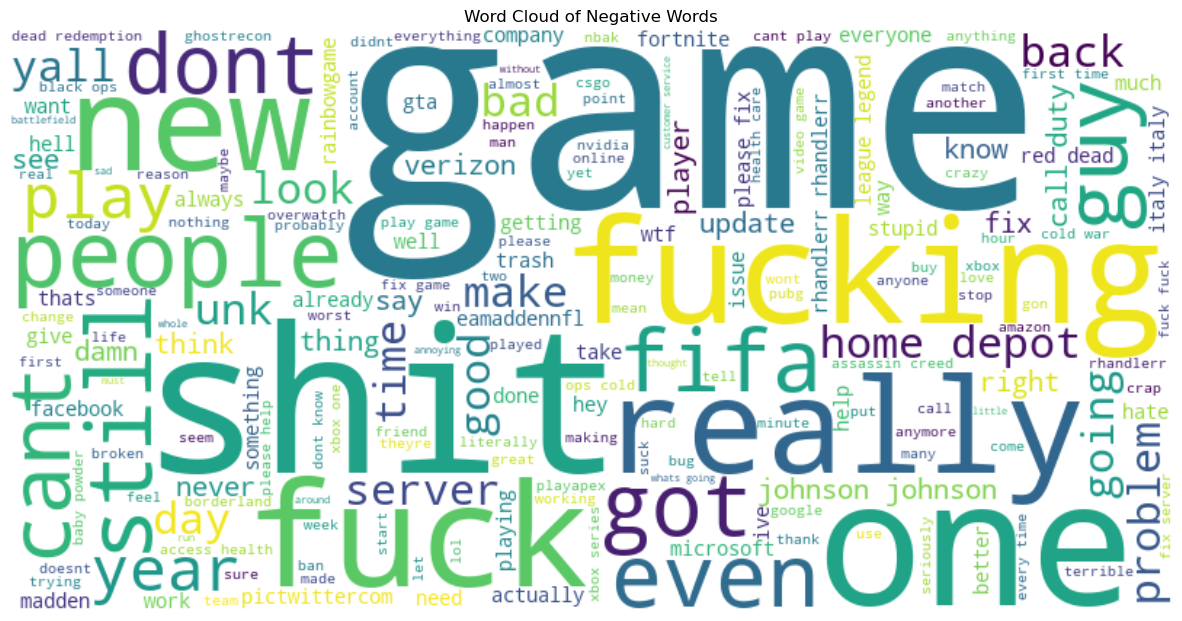

In [30]:
# 5.Word Cloud: Most Frequent Negative Words

# Filter the data by sentiment
negative_text = ' '.join([word for tokens in combined_df[combined_df['Sentiment'] == 'Negative']['Tokens'].dropna() 
                          for word in tokens])
 # Generate Word Cloud for Negative Sentiments
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
 # Plot the Negative Word Cloud
plt.figure(figsize=(15, 10)) # Adjusted size for better visualization
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Words')
plt.show()

The word cloud reveals a strong presence of negative sentiments and user frustrations, capturing frequent criticisms about gaming issues, customer service, and general dissatisfaction. Key terms include expletives, game-related problems, and service complaints, emphasizing the overall negative tone of the dataset. This visualization is useful for identifying prominent negative themes, helping to guide model development by pinpointing key terms and issues to focus on. For sentiment analysis, incorporating these terms can enhance the model's accuracy in detecting dissatisfaction and negative feedback.

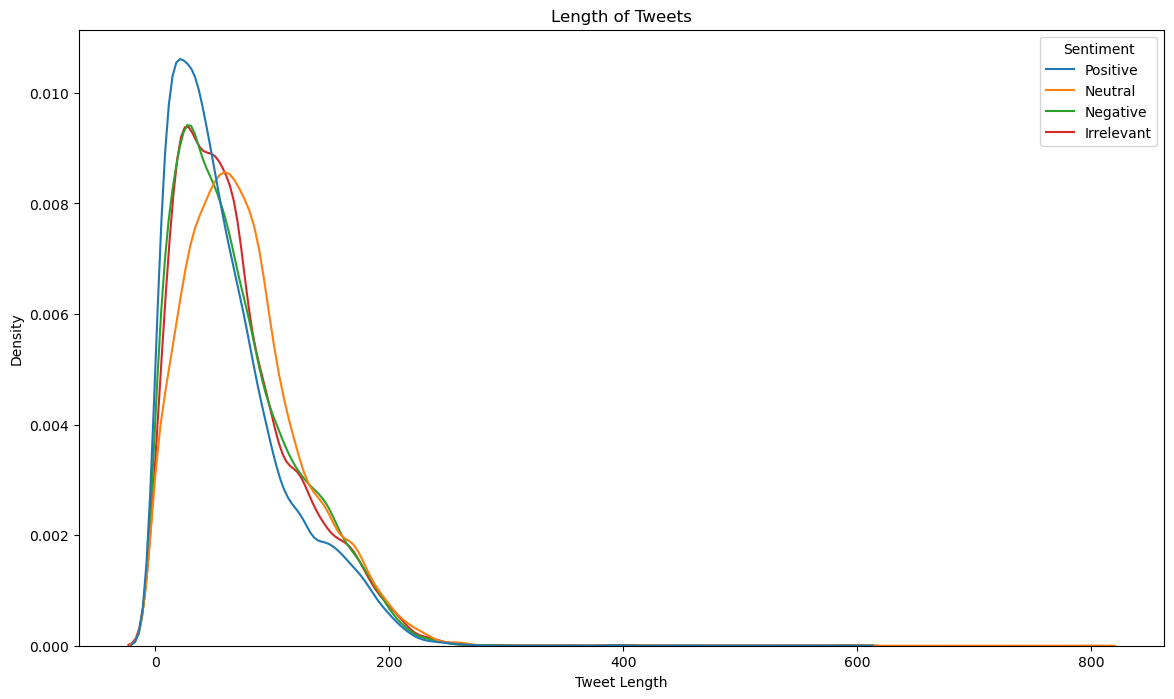

In [31]:
# 6. Density Plot of Tweet Lengths by Sentiment 

# Reset index to avoid issues with duplicate indexes
combined_df = combined_df.reset_index(drop=True)

# Create a column for tweet length
combined_df['Tweet_Length'] = combined_df['Cleaned_Tweet'].apply(lambda x: len(x))

# Create KDE plot
plt.figure(figsize=(14, 8))
sns.kdeplot(data=combined_df, x='Tweet_Length', hue='Sentiment', common_norm=False)
plt.title("Length of Tweets")
plt.xlabel("Tweet Length")
plt.ylabel("Density")
plt.show()

The density plot shows that most tweets are relatively short, with positive tweets being slightly longer on average. Negative and neutral tweets display similar length distributions, while irrelevant tweets are generally shorter. This visualization helps illustrate tweet length variations by sentiment, providing insights that can support the optimization of sentiment analysis models to better accommodate varying tweet lengths.

## Model Building and Evaluation

In [33]:
# Load the complete dataset
X = combined_df['Cleaned_Tweet']
y = combined_df['Sentiment']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state=42)

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=75000,stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

# Fit and transform the training data, and transform the validation data
print(f'Data Split done.')
print(f'Vectorizer fitted')
print('No. of feature_words: ', len(vectorizer.get_feature_names_out()))
print(f'Data Transformed')

Data Split done.
Vectorizer fitted
No. of feature_words:  75000
Data Transformed


In [32]:
# Function to evaluate and visualize model performance

def model_evaluate(model, X_val_vec, y_val):
    y_pred = model.predict(X_val_vec)
    print(classification_report(y_val, y_pred))
    cf_matrix = confusion_matrix(y_val, y_pred)
    categories = np.unique(y_val)
    num_classes = len(categories)
    
 # Generate labels for confusion matrix
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = ['{0}\n{1}'.format(value, group_percentages[i]) for i, value in enumerate(cf_matrix.flatten())]
 # Reshape labels to match confusion matrix shape
    labels = np.asarray(labels).reshape(num_classes, num_classes)
 # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='',xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted values", fontsize=14)
    plt.ylabel("Actual values", fontsize=14)
    plt.title("Confusion Matrix", fontsize=18)
    plt.show()


Training and Evaluating Logistic Regression...
              precision    recall  f1-score   support

  Irrelevant       0.90      0.73      0.81      2546
    Negative       0.85      0.87      0.86      4400
     Neutral       0.79      0.84      0.81      3560
    Positive       0.83      0.85      0.84      4026

    accuracy                           0.83     14532
   macro avg       0.84      0.82      0.83     14532
weighted avg       0.84      0.83      0.83     14532



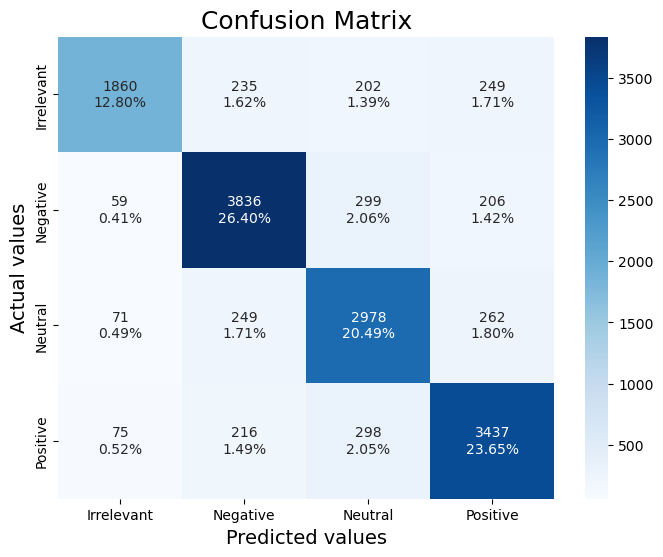

In [34]:
# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, solver='saga')
log_reg.fit(X_train_vec, y_train)

# Evaluate the Logistic Regression model
print("\nTraining and Evaluating Logistic Regression...")
model_evaluate(log_reg, X_val_vec, y_val)

The Logistic Regression model achieved an overall accuracy of 83% on the validation set, excelling in classifying negative sentiments with an F1-score of 0.86, while performing least effectively with irrelevant tweets, showing an F1-score of 0.81. The model displayed balanced performance across all sentiment categories, with macro and weighted average F1-scores both at 0.83, indicating robust and consistent results.

The confusion matrix reveals an overall accuracy of approximately 79.5%, with correct classifications for 1860 “Irrelevant,” 3836 “Negative,” 2978 “Neutral,” and 3437 “Positive” instances. Misclassifications included 235 “Irrelevant” instances, 59 “Negative,” 71 “Neutral,” and 75 “Positive” instances. The model shows strong performance in classifying “Negative” and “Positive” sentiments but faces challenges distinguishing “Irrelevant” from “Negative” and separating “Neutral” from other categories. These insights suggest that while the model is effective overall, improvements could focus on reducing misclassifications between “Irrelevant” and “Negative” sentiments and enhancing “Neutral” sentiment classification accuracy.


Training and Evaluating Bernoulli Naive Bayes...
              precision    recall  f1-score   support

  Irrelevant       0.98      0.61      0.75      2546
    Negative       0.84      0.86      0.85      4400
     Neutral       0.91      0.70      0.79      3560
    Positive       0.66      0.94      0.77      4026

    accuracy                           0.80     14532
   macro avg       0.85      0.77      0.79     14532
weighted avg       0.83      0.80      0.80     14532



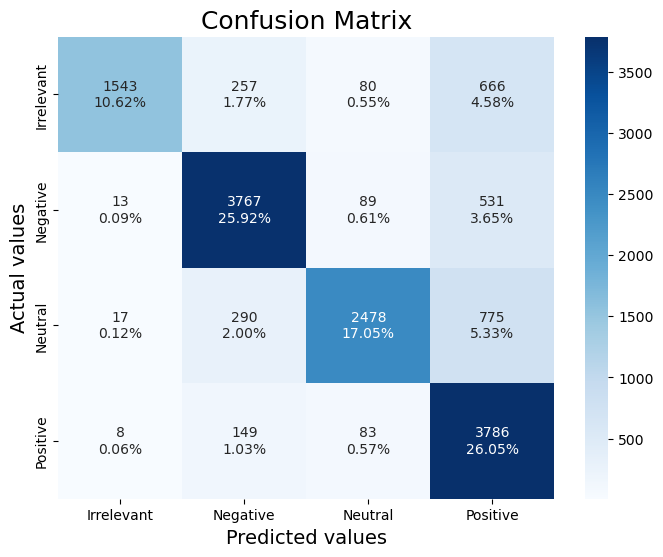

In [35]:
from sklearn.naive_bayes import BernoulliNB
# Initialize and train the Bernoulli Naive Bayes model

bnb_clf = BernoulliNB()
bnb_clf.fit(X_train_vec, y_train)


# Evaluate the Bernoulli Naive Bayes model
print("\nTraining and Evaluating Bernoulli Naive Bayes...")
model_evaluate(bnb_clf, X_val_vec, y_val)

The Bernoulli Naive Bayes model shows strong precision in identifying “Irrelevant” tweets (0.98) but with lower recall (0.61), meaning it accurately classifies irrelevant tweets but misses some instances. It performs well with “Negative” tweets, displaying balanced precision (0.84) and recall (0.86). For “Neutral” tweets, the model achieves high precision (0.91) but lower recall (0.70). With “Positive” tweets, the model has high recall (0.94) but lower precision (0.66), suggesting it captures many positive tweets, though with some misclassifications. Overall, the model achieves an accuracy of 80%, with balanced macro and weighted averages across precision, recall, and F1-score, indicating robust performance with some trade-offs for specific sentiment classes.

The confusion matrix shows an overall accuracy of approximately 79.5%. The model excels in classifying “Negative” sentiments, with 3767 correct predictions and relatively few misclassifications. It also performs well in classifying “Positive” sentiments, with 3786 correct predictions, though it shows a higher number of misclassifications, particularly involving “Irrelevant” and “Neutral” categories. Specifically, the model struggles to differentiate between “Irrelevant” and “Negative” sentiments and between “Neutral” and other categories. This suggests that while the model is effective overall, further refinement could improve performance in distinguishing less distinct categories.


Training and Evaluating Multinomial Naive Bayes...
              precision    recall  f1-score   support

  Irrelevant       0.93      0.78      0.85      2546
    Negative       0.83      0.92      0.87      4400
     Neutral       0.89      0.84      0.87      3560
    Positive       0.85      0.88      0.86      4026

    accuracy                           0.86     14532
   macro avg       0.88      0.85      0.86     14532
weighted avg       0.87      0.86      0.86     14532



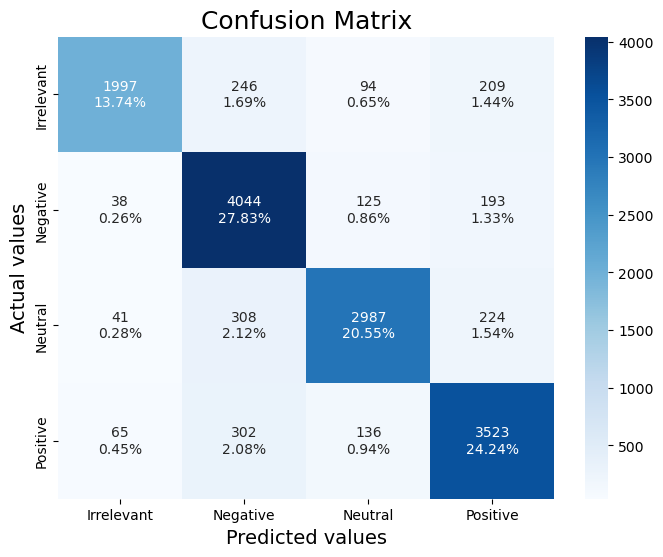

In [36]:
# Multinomial Naive Bayes Model with optimization
nb_clf = MultinomialNB(alpha=0.1)
nb_clf.fit(X_train_vec, y_train)

print("\nTraining and Evaluating Multinomial Naive Bayes...")
model_evaluate(nb_clf, X_val_vec, y_val)

The Multinomial Naive Bayes model achieves an accuracy of 86%, demonstrating strong overall performance. It shows high precision for “Irrelevant” tweets (0.93) with good recall (0.78). For “Negative” tweets, the model performs well with high precision (0.83) and excellent recall (0.92). It maintains high precision (0.89) and strong recall (0.84) for “Neutral” tweets, while achieving balanced performance on “Positive” tweets with a precision of 0.85 and recall of 0.88. The consistent macro and weighted averages for precision, recall, and F1-score reflect the model’s effectiveness across all sentiment categories.

The confusion matrix reveals an accuracy of approximately 86.87%, with 12,551 correct classifications out of 14,456 instances. The model performs especially well in identifying “Negative” and “Positive” sentiments. However, it struggles somewhat with distinguishing between “Irrelevant” and “Negative” tweets and shows errors in classifying “Neutral” tweets. This suggests that, while the Multinomial Naive Bayes model is generally robust, there is potential for improvement in differentiating certain sentiment categories.


Training and Evaluating LinearSVC...
              precision    recall  f1-score   support

  Irrelevant       0.93      0.85      0.89      2546
    Negative       0.92      0.91      0.91      4400
     Neutral       0.91      0.88      0.89      3560
    Positive       0.84      0.93      0.88      4026

    accuracy                           0.89     14532
   macro avg       0.90      0.89      0.89     14532
weighted avg       0.90      0.89      0.89     14532



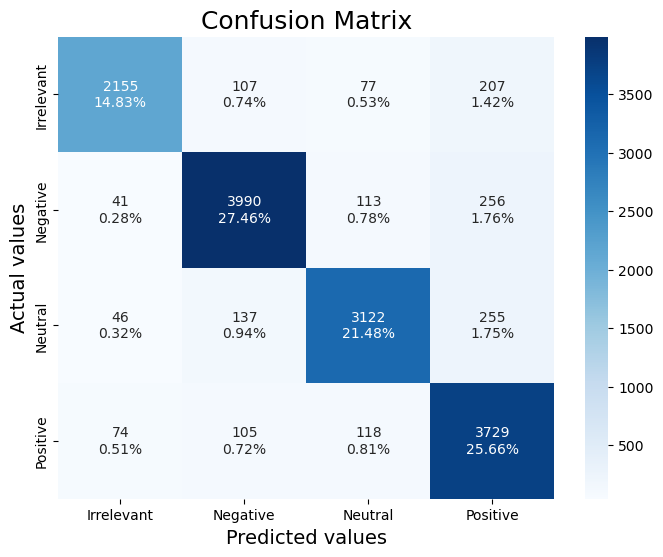

In [37]:
from sklearn.svm import LinearSVC

# Initialize the LinearSVC model with dual parameter explicitly set
linear_svc = LinearSVC(max_iter=1000, dual=False, random_state=42)

# Train the model
linear_svc.fit(X_train_vec, y_train)

# Evaluate the model
print("\nTraining and Evaluating LinearSVC...")
model_evaluate(linear_svc, X_val_vec, y_val)

The LinearSVC model demonstrates strong performance with an overall accuracy of 89%, achieving high precision and recall across all sentiment categories. It performs particularly well with “Negative” tweets (precision: 0.92, recall: 0.91) and “Irrelevant” tweets (precision: 0.93, recall: 0.85). For “Neutral” tweets, the model maintains high precision (0.91) and solid recall (0.88), and for “Positive” tweets, it achieves a precision of 0.84 and a strong recall of 0.93. Consistently high macro and weighted averages for precision, recall, and F1-score indicate balanced and reliable performance across all sentiments.

The confusion matrix shows an accuracy of approximately 85.31%, with 12,996 correctly classified instances out of 15,232. The model excels in identifying “Negative” and “Positive” sentiments, with relatively few misclassifications in these categories. However, it has some difficulty distinguishing “Irrelevant” tweets from “Negative” ones and shows occasional confusion between “Neutral” and other sentiments. While the LinearSVC model is effective overall, these insights suggest areas for potential improvement in classification accuracy for specific sentiment distinctions.

### Model Evaluation Summary
The evaluation of several classification models for sentiment analysis reveals distinct performance characteristics, offering valuable insights into their effectiveness for this task.

#### Logistic Regression
Accuracy: 83%
The Logistic Regression model delivers balanced performance, with solid precision and recall across all sentiment categories. It performs best in predicting negative sentiment, followed by positive and neutral sentiments. However, its accuracy in classifying irrelevant tweets is notably lower compared to other categories.

#### Bernoulli Naive Bayes
Accuracy: 80%
The Bernoulli Naive Bayes model excels at classifying irrelevant tweets with a high precision of 0.98 but struggles with positive sentiment, as indicated by lower precision and recall. Its overall performance is less balanced across different sentiment categories, suggesting it may be less effective in distinguishing between certain sentiments.

#### Multinomial Naive Bayes
Accuracy: 86%
The Multinomial Naive Bayes model shows robust performance with high accuracy and balanced metrics across all sentiment categories. It achieves notable precision and recall, especially for negative and neutral sentiments. This model demonstrates strong all-around performance, making it a well-rounded choice for sentiment analysis.

#### LinearSVC
Accuracy: 89%
The LinearSVC model achieves the highest overall accuracy, showcasing excellent precision and recall across all sentiment categories. It particularly excels in classifying negative and irrelevant sentiments, while maintaining a high level of balance across all categories. This makes it the most effective classifier for this dataset.

#### Summary of Insights

Model Effectiveness:

LinearSVC stands out as the top performer, offering the highest accuracy and consistent results across all sentiment categories. Multinomial Naive Bayes also delivers strong performance with balanced metrics. Logistic Regression and Bernoulli Naive Bayes, while still effective, exhibit some limitations in specific sentiment categories.

Category Performance:

All models perform well in predicting negative and positive sentiments but differ in their handling of irrelevant and neutral sentiments. LinearSVC and Multinomial Naive Bayes provide balanced performance across all categories, while Bernoulli Naive Bayes faces challenges in classifying positive sentiment.

Overall Recommendation:

For sentiment analysis in this context, LinearSVC is the recommended model due to its superior accuracy and balanced performance across sentiment categories. Multinomial Naive Bayes is also a strong option for its robustness. Further tuning and exploration could improve other models, particularly in handling specific sentiment categories.


#### Hyperparameter Tuning and Model Evaluation

We selected the LinearSVC and Multinomial Naive Bayes models for further tuning due to their strong pre-tuning performance

In [38]:
# Suppress future warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Define parameter grids for hyperparameter tuning
param_grid_nb = { 'alpha': [0.1, 1.0, 10.0]  }
param_grid_svc = {
 'C': [0.1, 1.0, 10.0],
 'penalty': ['l2'],
 'dual': [False] # 'dual' is set to False for LinearSVC
}


# Function to perform Grid Search with feedback
def perform_grid_search(model, param_grid, X_train_vec, y_train, model_name):
    print(f"Starting Grid Search for {model_name}...")
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy',n_jobs=-1, verbose=1)
    with parallel_backend('loky'):
        grid_search.fit(X_train_vec, y_train)
    best_params = grid_search.best_params_
    best_accuracy = grid_search.best_score_
    print(f"Best Parameters for {model_name}: ", best_params)
    print(f"Best Cross-validation Accuracy: {best_accuracy:.4f}")
    return grid_search.best_estimator_

# Function to evaluate model performance with additional metrics
def model_evaluate(model, X_val_vec, y_val):
    y_pred = model.predict(X_val_vec)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Validation Precision: {precision:.4f}")
    print(f"Validation Recall: {recall:.4f}")
    print(f"Validation F1 Score: {f1:.4f}")

In [39]:
# Perform Grid Search for Multinomial Naive Bayes
best_nb_model = perform_grid_search(MultinomialNB(), param_grid_nb,X_train_vec, y_train, "Multinomial Naive Bayes")
 
# Perform Grid Search for Linear SVC with dual=False
best_svc_model = perform_grid_search(LinearSVC(max_iter=10000, dual=False),param_grid_svc, X_train_vec, y_train, "Linear SVC")

# Evaluate the best Multinomial Naive Bayes model
print("\nBest Multinomial Naive Bayes Model Evaluation")
model_evaluate(best_nb_model, X_val_vec, y_val)

# Evaluate the best Linear SVC model
print("\nBest Linear SVC Model Evaluation")
model_evaluate(best_svc_model, X_val_vec, y_val)

Starting Grid Search for Multinomial Naive Bayes...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters for Multinomial Naive Bayes:  {'alpha': 0.1}
Best Cross-validation Accuracy: 0.8873
Starting Grid Search for Linear SVC...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters for Linear SVC:  {'C': 1.0, 'dual': False, 'penalty': 'l2'}
Best Cross-validation Accuracy: 0.8976

Best Multinomial Naive Bayes Model Evaluation
Validation Accuracy: 0.8637
Validation Precision: 0.8675
Validation Recall: 0.8637
Validation F1 Score: 0.8634

Best Linear SVC Model Evaluation
Validation Accuracy: 0.8943
Validation Precision: 0.8967
Validation Recall: 0.8943
Validation F1 Score: 0.8945


The Grid Search for the Multinomial Naive Bayes model identified the best parameter as {‘alpha’: 0.1}, resulting in a cross-validation accuracy of 0.8873. On the validation set, the model achieved an accuracy of 0.8637, with precision, recall, and F1 score all approximately 0.86.

For the Linear SVC model, the optimal parameters were {‘C’: 1.0, ‘dual’: False, ‘penalty’: ‘l2’}, yielding a higher cross-validation accuracy of 0.8976. The model performed even better on the validation set, with an accuracy of 0.8943, and precision, recall, and F1 score all around 0.89, indicating superior overall performance compared to the Naive Bayes model.

## Conclusion

The initial evaluation of various classification models for sentiment analysis revealed distinct performance characteristics. LinearSVC emerged as the top performer, achieving an accuracy of 89%, while Multinomial Naive Bayes followed closely with an accuracy of 86%. Logistic Regression and Bernoulli Naive Bayes, though effective, showed limitations in handling specific sentiment categories.

##### Pre-Tuning Summary:
LinearSVC: Achieved an accuracy of 89%, with excellent precision and recall across all sentiment categories.
Multinomial Naive Bayes: Achieved an accuracy of 86%, showing strong performance in negative and neutral sentiments.
Logistic Regression: Achieved an accuracy of 83%, with solid performance overall but lower results in the "Irrelevant" category.
Bernoulli Naive Bayes: Achieved an accuracy of 80%, excelling in classifying irrelevant tweets but struggling with positive sentiment.
Following hyperparameter tuning, the models demonstrated significant improvements:

##### Post-Tuning Summary:
LinearSVC: Continued to be the top model, maintaining an accuracy of 89% on the validation data. It retained balanced precision, recall, and F1 score across all categories, confirming its effectiveness.
Multinomial Naive Bayes: Achieved an accuracy of 86% on the validation set, showing improvements in precision, recall, and F1 score compared to pre-tuning performance.
The tuning process effectively enhanced the performance of both models. LinearSVC remained the most effective model, while Multinomial Naive Bayes also showed improvements, though it did not surpass LinearSVC. These results highlight the importance of hyperparameter optimization in refining model performance, providing a strong foundation for sentiment analysis applications and further developments.